### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
%matplotlib inline
import nltk
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from adzuna.models.cnn_pretrained import SalaryPredictor as CNNPretrainedEmbeddingSalaryPredictor
from adzuna.models.cnn_deep import CNNSalaryPredictor
from adzuna.models.rnn import RNNSalaryPredictor
from adzuna.pipelines.data_transform import *
from adzuna.pipelines.train import TrainExecutor
from adzuna.pipelines.preprocess import BatchPreprocessor
from adzuna.pipelines.data_transform import DataProcessor
from adzuna.config import *
from adzuna.utils import *
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

### Load data and preprocess data

In [4]:
%%time
data = DataProcessor("./Train_rev1.zip", TEXT_COLUMNS, CATEGORICAL_COLUMNS, COMPANY_COLUMN, TARGET_COLUMN).process()
data.shape

CPU times: user 27.5 s, sys: 687 ms, total: 28.1 s
Wall time: 28.2 s


(244768, 13)

In [5]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671


### Leave only words that occured >= 10 times

In [6]:
%%time
# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = get_frequent_tokens(data, TEXT_COLUMNS, min_count=10)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

CPU times: user 19.7 s, sys: 2.72 s, total: 22.4 s
Wall time: 22.3 s


In [7]:
token_to_id = {token : ind for ind, token in enumerate(tokens)}

In [8]:
%%time
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[CATEGORICAL_COLUMNS].apply(dict, axis=1))

CPU times: user 12.5 s, sys: 177 µs, total: 12.5 s
Wall time: 12.6 s


DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### Split the data

In [9]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
batch_preprocessor = BatchPreprocessor(token_to_id, categorical_vectorizer, device, 
                                       title_max_len=TITLE_MAX_LEN, desc_max_len=DESC_MAX_LEN)

In [12]:
bdata = batch_preprocessor.make_batch(data_train[:3])

In [13]:
bdata

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
         [10609, 30412, 17746,    33,  8705, 29157,    65,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1

## Models

### Use Glove embeddings

In [15]:
%%time
import gensim.downloader as api
model = api.load('glove-twitter-100')

[==================================----------------] 69.5% 268.9/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 79.1% 306.3/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 86.8% 336.1/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.7% 370.4/387.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 387.1/387.1MB downloaded
CPU times: user 2min 33s, sys: 11.6 s, total: 2min 45s
Wall time: 2min 38s


In [16]:
embedding_matrix = get_embedding_matrix(model, tokens)
num_of_cat_features = len(categorical_vectorizer.vocabulary_)

# CNN with pretrained

Simple CNN model with 1 convolutional layer and 1 pooling layer for title and description

In [17]:
salary_model = CNNPretrainedEmbeddingSalaryPredictor(embedding_matrix,num_of_cat_features, 
                                                     TITLE_MAX_LEN, DESC_MAX_LEN).to(device)
salary_model(bdata)

tensor([ 0.0581, -0.1306, -0.1566], device='cuda:0', grad_fn=<ViewBackward>)

## L1 loss, adam optimizer

In [18]:
criterion = nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(salary_model.parameters(), lr=1e-4)
train_executor = TrainExecutor(salary_model, criterion, optimizer, batch_preprocessor)

In [19]:
%%time
metrics_data = train_executor.train(10, data_train, data_val)

EPOCH: 0



 results:
Mean square error: 0.10856
Mean absolute error: 0.24363
EPOCH: 1



 results:
Mean square error: 0.08945
Mean absolute error: 0.21893
EPOCH: 2



 results:
Mean square error: 0.08183
Mean absolute error: 0.20884
EPOCH: 3



 results:
Mean square error: 0.07779
Mean absolute error: 0.20299
EPOCH: 4



 results:
Mean square error: 0.07583
Mean absolute error: 0.19971
EPOCH: 5



 results:
Mean square error: 0.07438
Mean absolute error: 0.19745
EPOCH: 6



 results:
Mean square error: 0.07555
Mean absolute error: 0.19984
EPOCH: 7



 results:
Mean square error: 0.07156
Mean absolute error: 0.19398
EPOCH: 8



 results:
Mean square error: 0.07153
Mean absolute error: 0.19452
EPOCH: 9



 results:
Mean square error: 0.07236
Mean absolute error: 0.19457
CPU times: user 25min 8s, sys: 10.6 s, total: 25min 19s
Wall time: 25min 30s


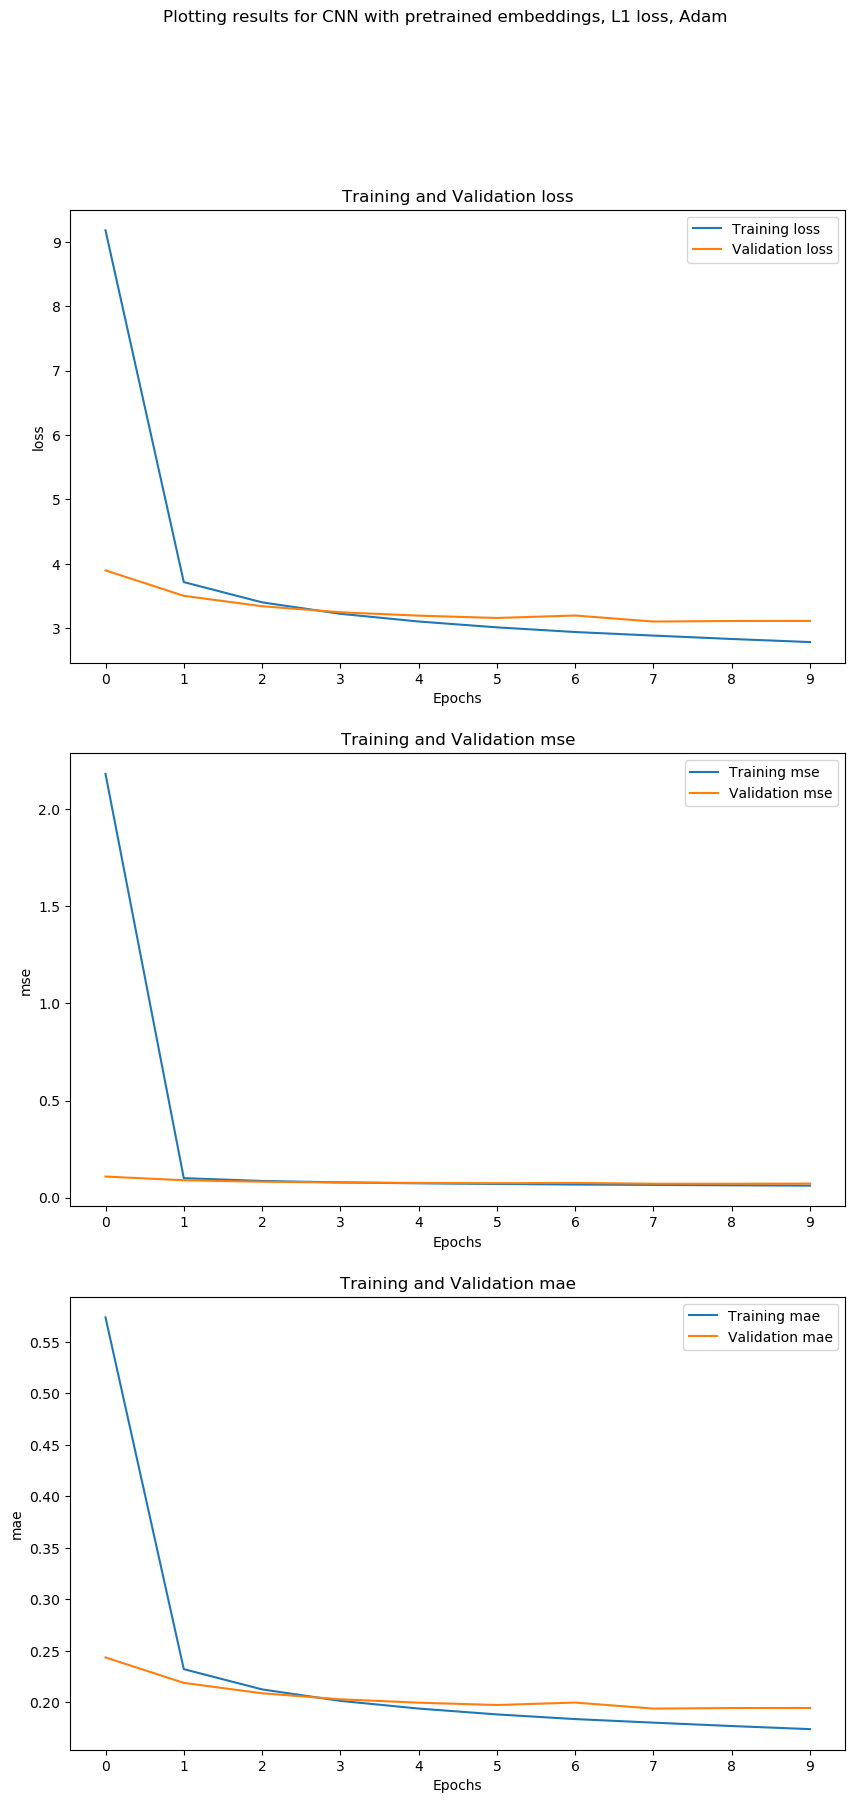

In [20]:
plot_metric(metrics_data, 'CNN with pretrained embeddings, L1 loss, Adam')

## L2 loss, SGD optimizer

In [21]:
salary_model = CNNPretrainedEmbeddingSalaryPredictor(embedding_matrix,num_of_cat_features, 
                                                     TITLE_MAX_LEN, DESC_MAX_LEN).to(device)

In [23]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(salary_model.parameters(), lr=1e-4)
train_executor = TrainExecutor(salary_model, criterion, optimizer, batch_preprocessor)

In [24]:
%%time
metrics_data = train_executor.train(10, data_train, data_val)

EPOCH: 0



 results:
Mean square error: 0.11061
Mean absolute error: 0.25198
EPOCH: 1



 results:
Mean square error: 0.09636
Mean absolute error: 0.23379
EPOCH: 2



 results:
Mean square error: 0.08666
Mean absolute error: 0.22066
EPOCH: 3



 results:
Mean square error: 0.08385
Mean absolute error: 0.21703
EPOCH: 4



 results:
Mean square error: 0.07926
Mean absolute error: 0.21067
EPOCH: 5



 results:
Mean square error: 0.08148
Mean absolute error: 0.21539
EPOCH: 6



 results:
Mean square error: 0.07862
Mean absolute error: 0.21051
EPOCH: 7



 results:
Mean square error: 0.07948
Mean absolute error: 0.21192
EPOCH: 8



 results:
Mean square error: 0.07573
Mean absolute error: 0.20503
EPOCH: 9



 results:
Mean square error: 0.07647
Mean absolute error: 0.20634
CPU times: user 19min 58s, sys: 17.1 s, total: 20min 15s
Wall time: 20min 21s


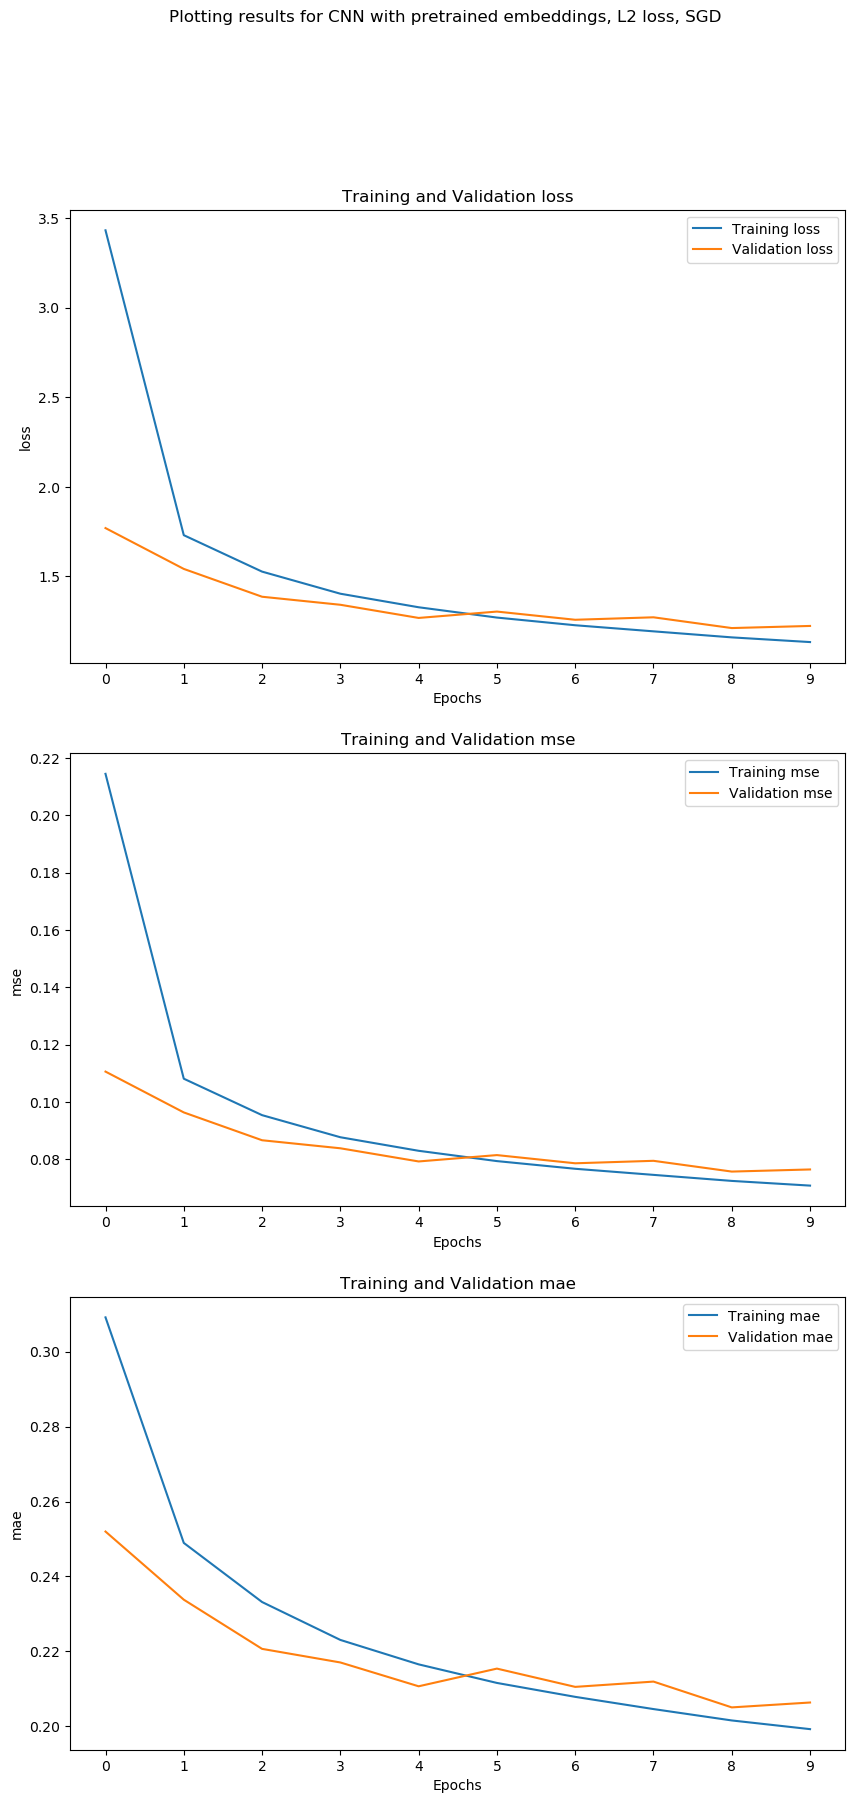

In [25]:
plot_metric(metrics_data, 'CNN with pretrained embeddings, L2 loss, SGD')

MAE = 0.21 means that 
<br>
log(y1) - log(y2) = 0.21
<br>
log(y1 / y2) = 0.21
<br>
y1 / y2 = 1.23
<br>
y1 = 1.23 * y2
<br>

then if real value y1 = 30000 it means that we predict 30 000 / 1.23 = 24390

### CNN architecture

# RNN

## Bidirectional

### L1 loss, Adam

LSTM based models: one-directional and bidirectional

In [27]:
rnn_salary_model = RNNSalaryPredictor(embedding_matrix, num_of_cat_features, TITLE_MAX_LEN, DESC_MAX_LEN, bidirectional=True).to(device)
rnn_salary_model(bdata)

tensor([0.1013, 0.1267, 0.1106], device='cuda:0', grad_fn=<ViewBackward>)

In [28]:
criterion = nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(rnn_salary_model.parameters(), lr=1e-4)
train_executor = TrainExecutor(rnn_salary_model, criterion, optimizer, batch_preprocessor)

In [29]:
%%time
metrics_data = train_executor.train(10, data_train, data_val)

EPOCH: 0



 results:
Mean square error: 0.08489
Mean absolute error: 0.21614
EPOCH: 1



 results:
Mean square error: 0.07888
Mean absolute error: 0.20518
EPOCH: 2



 results:
Mean square error: 0.07933
Mean absolute error: 0.20676
EPOCH: 3



 results:
Mean square error: 0.08062
Mean absolute error: 0.20856
EPOCH: 4



 results:
Mean square error: 0.07200
Mean absolute error: 0.19369
EPOCH: 5



 results:
Mean square error: 0.07444
Mean absolute error: 0.20091
EPOCH: 6



 results:
Mean square error: 0.06919
Mean absolute error: 0.18991
EPOCH: 7



 results:
Mean square error: 0.06871
Mean absolute error: 0.18887
EPOCH: 8



 results:
Mean square error: 0.07199
Mean absolute error: 0.19497
EPOCH: 9



 results:
Mean square error: 0.06709
Mean absolute error: 0.18657
CPU times: user 1h 30min 15s, sys: 36.9 s, total: 1h 30min 51s
Wall time: 1h 30min 48s


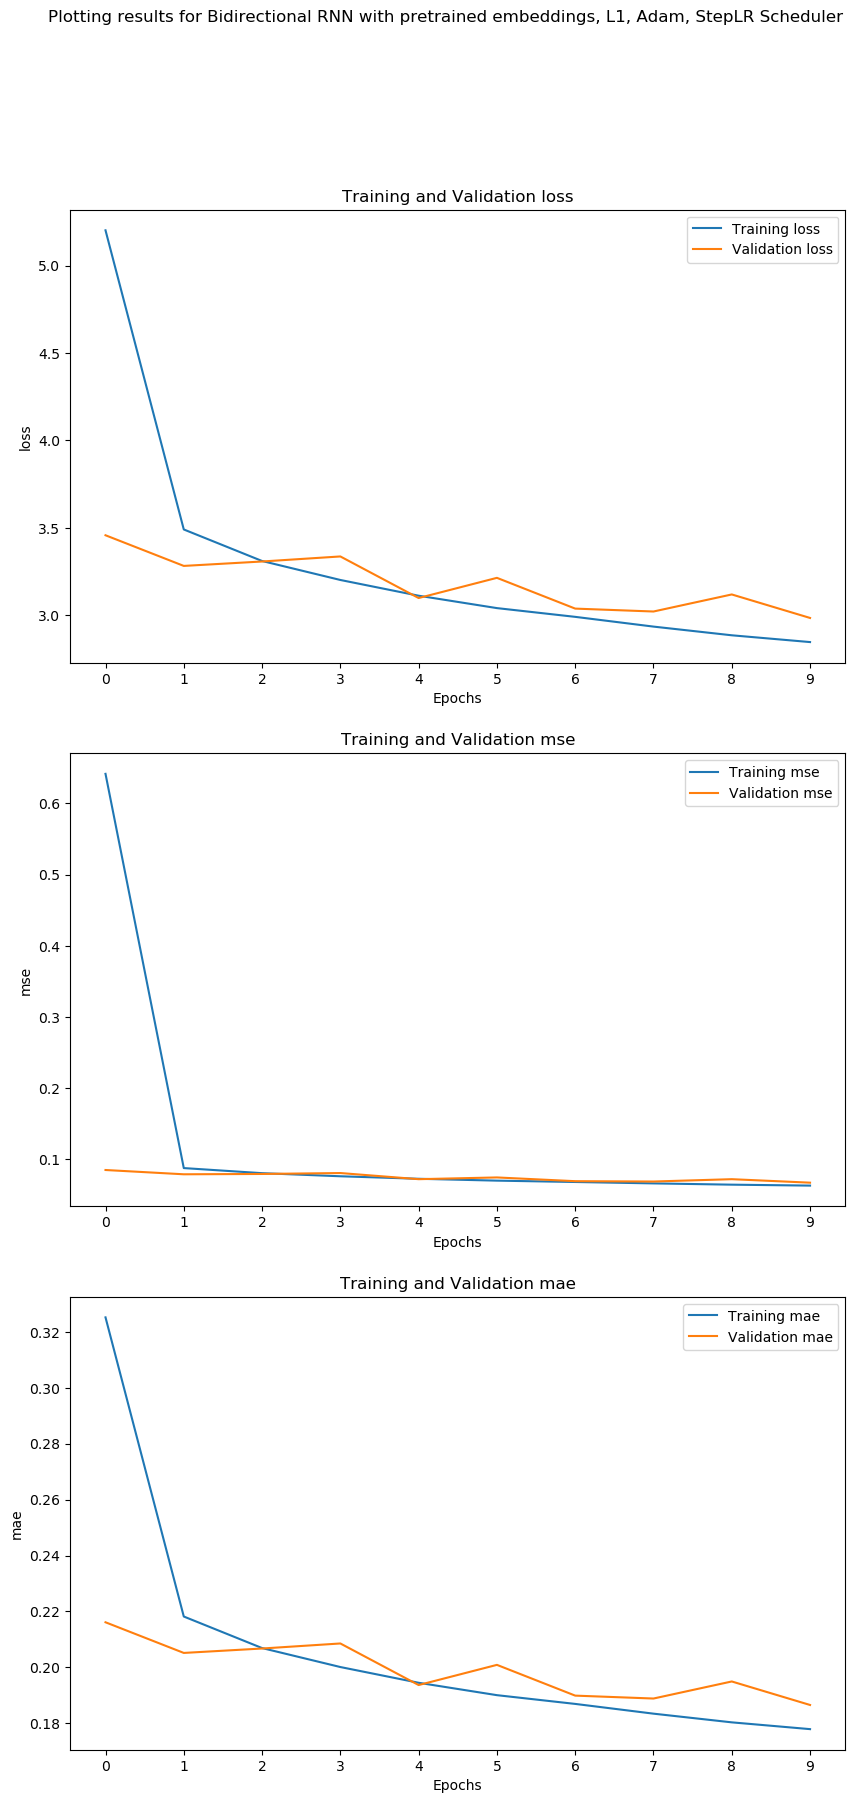

In [30]:
plot_metric(metrics_data, 'Bidirectional RNN with pretrained embeddings, L1, Adam, StepLR Scheduler')

### L2 loss, SGD

In [31]:
rnn_salary_model = RNNSalaryPredictor(embedding_matrix, num_of_cat_features, TITLE_MAX_LEN, DESC_MAX_LEN, bidirectional=True).to(device)

In [32]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(rnn_salary_model.parameters(), lr=1e-4)
train_executor = TrainExecutor(rnn_salary_model, criterion, optimizer, batch_preprocessor)

In [33]:
%%time
metrics_data = train_executor.train(10, data_train, data_val)

EPOCH: 0



 results:
Mean square error: 0.18488
Mean absolute error: 0.33707
EPOCH: 1



 results:
Mean square error: 0.11491
Mean absolute error: 0.26086
EPOCH: 2



 results:
Mean square error: 0.10629
Mean absolute error: 0.25006
EPOCH: 3



 results:
Mean square error: 0.10351
Mean absolute error: 0.24557
EPOCH: 4



 results:
Mean square error: 0.09761
Mean absolute error: 0.23604
EPOCH: 5



 results:
Mean square error: 0.10296
Mean absolute error: 0.24587
EPOCH: 6



 results:
Mean square error: 0.10219
Mean absolute error: 0.24412
EPOCH: 7



 results:
Mean square error: 0.09462
Mean absolute error: 0.23187
EPOCH: 8



 results:
Mean square error: 0.09387
Mean absolute error: 0.23108
EPOCH: 9



 results:
Mean square error: 0.09170
Mean absolute error: 0.22860
CPU times: user 1h 25min 13s, sys: 34 s, total: 1h 25min 47s
Wall time: 1h 25min 44s


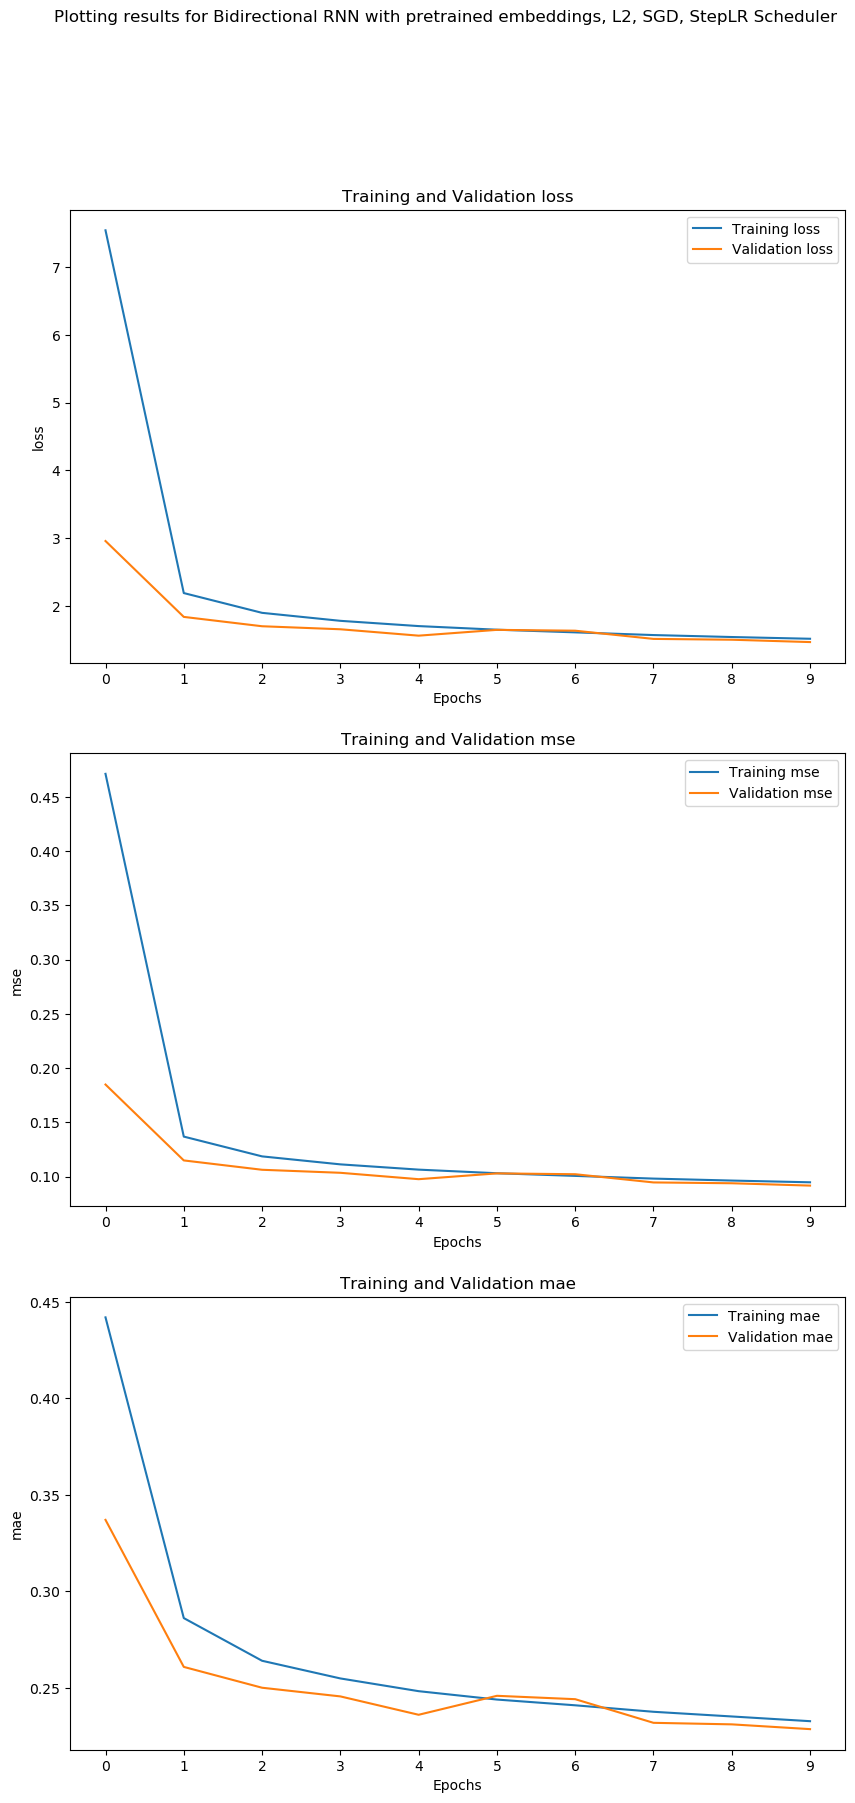

In [34]:
plot_metric(metrics_data, 'Bidirectional RNN with pretrained embeddings, L2, SGD, StepLR Scheduler')

## One-directional

### L1 loss, Adam optimizer

In [35]:
rnn_salary_model = RNNSalaryPredictor(embedding_matrix, num_of_cat_features, TITLE_MAX_LEN, DESC_MAX_LEN).to(device)
rnn_salary_model(bdata)

tensor([ 0.0232,  0.0310, -0.0021], device='cuda:0', grad_fn=<ViewBackward>)

In [36]:
criterion = nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(rnn_salary_model.parameters(), lr=1e-4)
train_executor = TrainExecutor(rnn_salary_model, criterion, optimizer, batch_preprocessor)

In [37]:
%%time
metrics_data = train_executor.train(10, data_train, data_val)

EPOCH: 0



 results:
Mean square error: 0.09383
Mean absolute error: 0.23178
EPOCH: 1



 results:
Mean square error: 0.08257
Mean absolute error: 0.21345
EPOCH: 2



 results:
Mean square error: 0.08468
Mean absolute error: 0.21531
EPOCH: 3



 results:
Mean square error: 0.07851
Mean absolute error: 0.20490
EPOCH: 4



 results:
Mean square error: 0.07276
Mean absolute error: 0.19601
EPOCH: 5



 results:
Mean square error: 0.07873
Mean absolute error: 0.20735
EPOCH: 6



 results:
Mean square error: 0.07110
Mean absolute error: 0.19311
EPOCH: 7



 results:
Mean square error: 0.07083
Mean absolute error: 0.19292
EPOCH: 8



 results:
Mean square error: 0.06984
Mean absolute error: 0.19120
EPOCH: 9



 results:
Mean square error: 0.06866
Mean absolute error: 0.19022
CPU times: user 1h 22s, sys: 26.6 s, total: 1h 48s
Wall time: 1h 50s


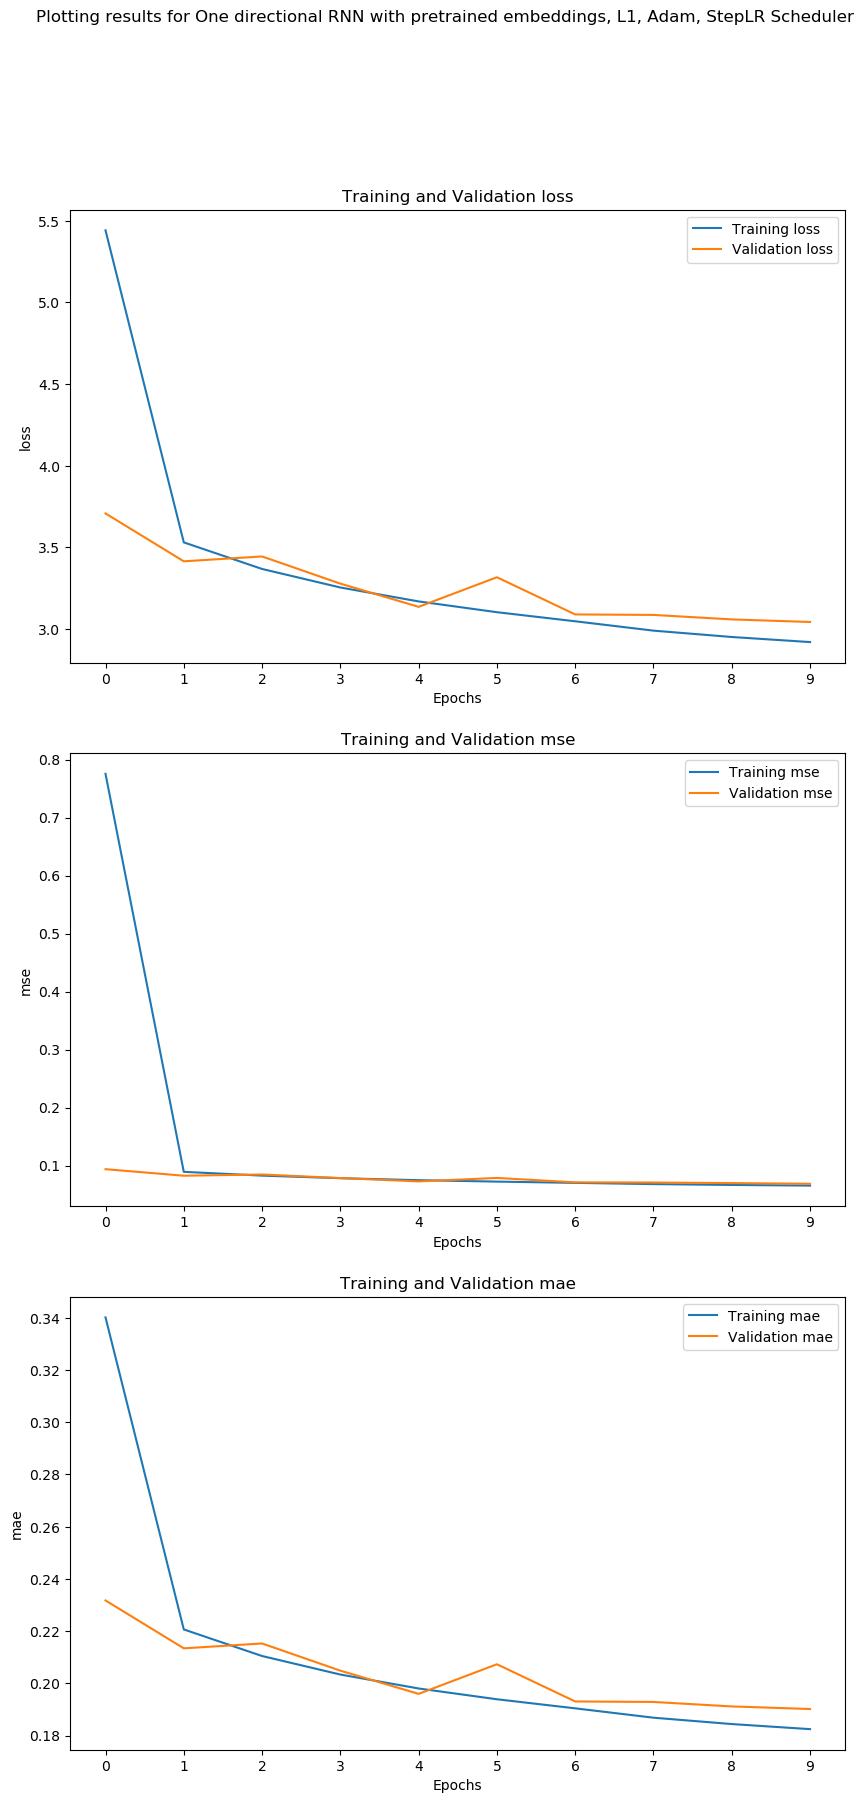

In [38]:
plot_metric(metrics_data, 'One directional RNN with pretrained embeddings, L1, Adam, StepLR Scheduler')

### L2, SGD

In [39]:
rnn_salary_model = RNNSalaryPredictor(embedding_matrix, num_of_cat_features, TITLE_MAX_LEN, DESC_MAX_LEN).to(device)

In [40]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(rnn_salary_model.parameters(), lr=1e-4)
train_executor = TrainExecutor(rnn_salary_model, criterion, optimizer, batch_preprocessor)

In [41]:
%%time
metrics_data = train_executor.train(10, data_train, data_val)

EPOCH: 0



 results:
Mean square error: 0.15970
Mean absolute error: 0.29980
EPOCH: 1



 results:
Mean square error: 0.14397
Mean absolute error: 0.28460
EPOCH: 2



 results:
Mean square error: 0.13628
Mean absolute error: 0.27858
EPOCH: 3



 results:
Mean square error: 0.12748
Mean absolute error: 0.27242
EPOCH: 4



 results:
Mean square error: 0.13566
Mean absolute error: 0.28087
EPOCH: 5



 results:
Mean square error: 0.15153
Mean absolute error: 0.30738
EPOCH: 6



 results:
Mean square error: 0.11691
Mean absolute error: 0.26041
EPOCH: 7



 results:
Mean square error: 0.11721
Mean absolute error: 0.26034
EPOCH: 8



 results:
Mean square error: 0.13057
Mean absolute error: 0.27755
EPOCH: 9



 results:
Mean square error: 0.10779
Mean absolute error: 0.25001
CPU times: user 56min 9s, sys: 25.1 s, total: 56min 34s
Wall time: 56min 37s


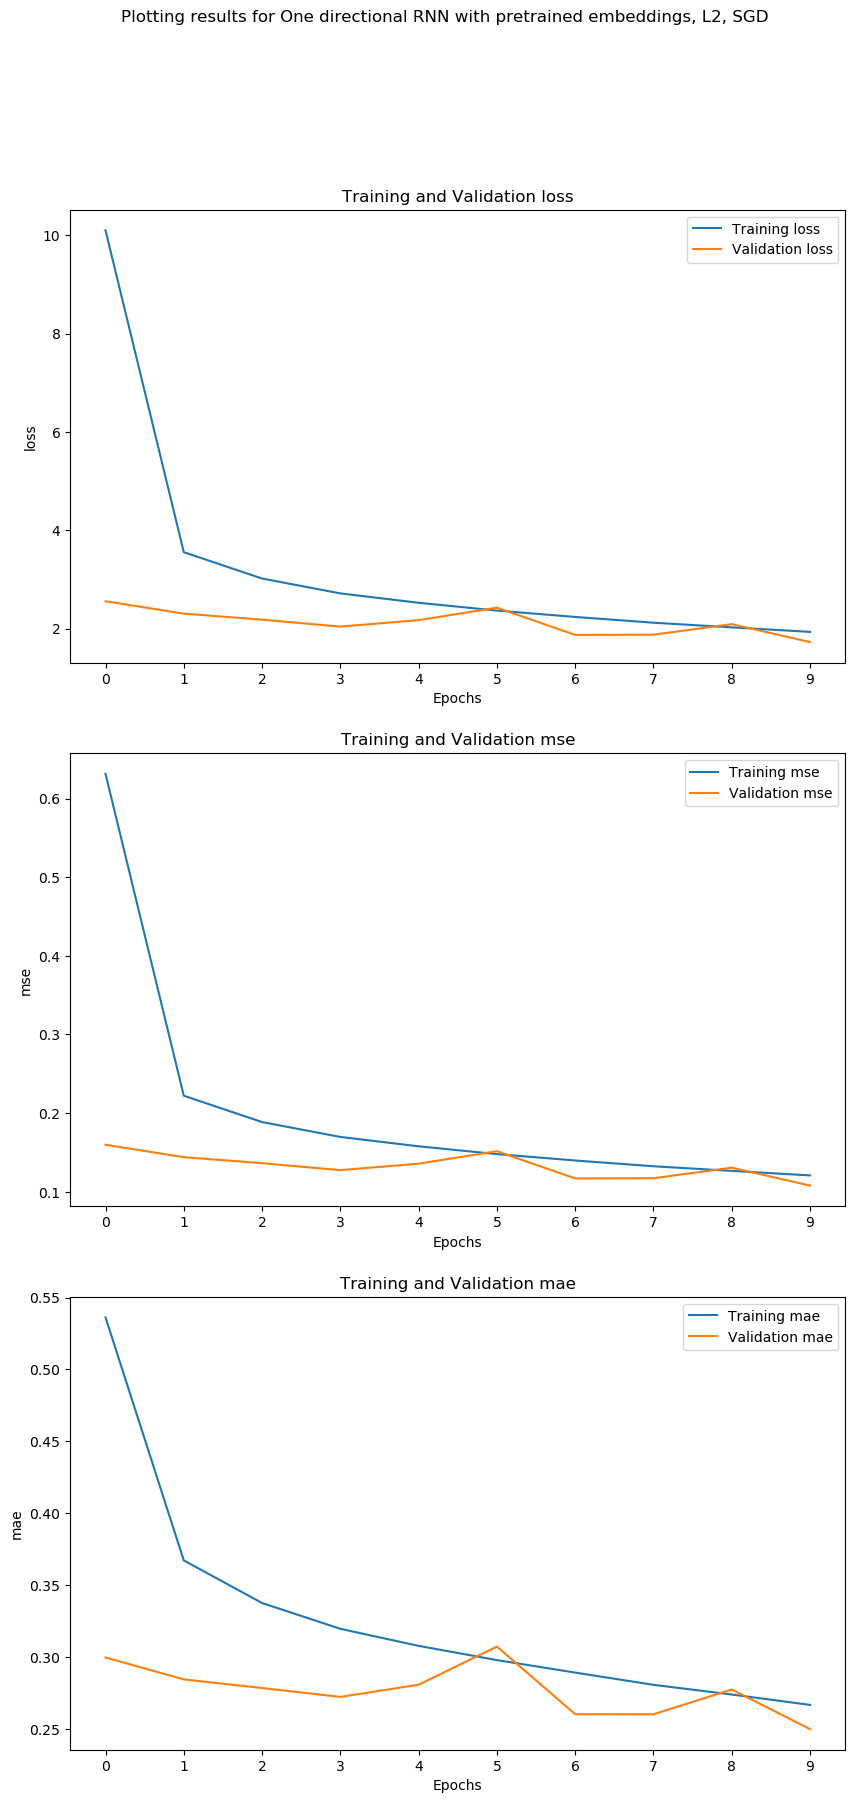

In [42]:
plot_metric(metrics_data, 'One directional RNN with pretrained embeddings, L2, SGD')

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!